## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv("ab_data.csv")
df.head()

FileNotFoundError: File b'ab_data.csv' does not exist

b. Use the below cell to find the number of rows in the dataset.

In [297]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [298]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [299]:
df.query('converted == 1')['user_id'].count()/df.shape[0]

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [300]:
df.query('(landing_page == "new_page" and group != "treatment") or (landing_page != "new_page" and group == "treatment")')['user_id'].count()


3893

f. Do any of the rows have missing values?

In [301]:
df.isnull().count()

user_id         294478
timestamp       294478
group           294478
landing_page    294478
converted       294478
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [302]:
df2 = df.drop(df.query('(group == "treatment" and landing_page != "new_page") or (group != "treatment" and landing_page == "new_page") or (group == "control" and landing_page != "old_page") or (group != "control" and landing_page == "old_page")').index)

In [303]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [304]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [305]:
df2[df2.duplicated(['user_id'])]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [306]:
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [307]:
# get the sulotion from https://stackoverflow.com/questions/39802076/pandas-drop-row-based-on-index-vs-ix
df2.drop(2893, inplace=True)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [308]:
df2.query('converted == 1')['user_id'].count()/df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [309]:
df2.query('group == "control" and converted == 1')['user_id'].count()/df2.query('group == "control"').shape[0]

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [310]:
df2.query('group == "treatment" and converted == 1')['user_id'].count()/df2.query('group == "treatment"').shape[0]


0.11880806551510564

d. What is the probability that an individual received the new page?

In [311]:
df2.query('landing_page == "new_page"')['user_id'].count()/df2.shape[0]

0.5000619442226688

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

**There is no evidence that one page leads to more conversions As the probabilities are almost similar**


<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**$H_{0}$ = $p_{old}$ >= $p_{new}$**

**$H_{1}$ = $p_{old}$ < $p_{new}$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [312]:
# calulate the converted success rate regardless of page
p_new = df2.query('converted == 1')['user_id'].nunique()/df2['user_id'].nunique()

p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [313]:
p_old = df2.query('converted == 1')['user_id'].nunique()/df2['user_id'].nunique()

p_old

0.11959708724499628

c. What is $n_{new}$?

In [314]:
#calculate  number of individual received the new page

n_new = df2.query('landing_page == "new_page"')['user_id'].nunique()

n_new

145310

d. What is $n_{old}$?

In [315]:
#calculate  number of individual received the old page 

n_old = df2.query('landing_page == "old_page"')['user_id'].nunique()

n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [316]:
new_page_converted = np.random.choice([0,1],n_new, p=(p_new,1-p_new))

new_page_converted


array([0, 1, 1, ..., 0, 1, 1])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [317]:
old_page_converted = np.random.choice([0,1],n_old, p=(p_old,1-p_old))

old_page_converted

array([1, 1, 1, ..., 1, 1, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [318]:
p = new_page_converted.mean() - old_page_converted.mean()

p

0.0004633179965669587

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [319]:
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.choice([0,1],n_new, p=(p_new,1-p_new))
    old_page_converted = np.random.choice([0,1],n_old, p=(p_old,1-p_old))
    
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

(array([  28.,  186.,  828., 2030., 2932., 2532., 1120.,  296.,   39.,
           9.]),
 array([-0.00434083, -0.00340962, -0.00247841, -0.00154719, -0.00061598,
         0.00031523,  0.00124644,  0.00217766,  0.00310887,  0.00404008,
         0.00497129]),
 <a list of 10 Patch objects>)

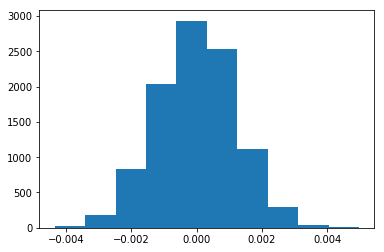

In [320]:
p_diffs = np.array(p_diffs)
plt.hist(p_diffs)

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [344]:
# Create number of users with all new_page users and all old_page users
convert_new = df2.query('converted == 1 and landing_page == "new_page"')['user_id'].nunique()
convert_old = df2.query('converted == 1 and landing_page == "old_page"')['user_id'].nunique()

# Compute converted rate
convert_new_rate = convert_new/ n_new 
convert_old_rate = convert_old/ n_old

# Compute observed difference in converted rate 
obs_diff = convert_new_rate - convert_old_rate

obs_diff

-0.0015782389853555567

In [322]:
# create distribution under the null hypothesis
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

#Compute proportion of the p_diffs are greater than the actual difference observed in ab_data.csv
(null_vals > obs_diff).mean()

0.9064

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**After we measure the p-value, with a type I error rate of 0.05, and we assume the null hypothesis is true. The data shows the probability of observing our difference or even larger between the two pages is 90%**

**As of this is such a high probability, it is very likely in terms of conversion rates we could have observed this difference from two pages that do not differ.**

**So, we fail to reject the null hypothesis.**

**The P value is the probability of finding the observed, or more extreme results when the null hypothesis $H_{0}$ of a study question is true**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [323]:
import statsmodels.api as sm

convert_old = df2.query('converted == 1 and landing_page == "old_page"')['user_id'].nunique()
convert_new = df2.query('converted == 1 and landing_page == "new_page"')['user_id'].nunique()
n_old = df2.query('landing_page == "old_page"')['user_id'].nunique()
n_new = df2.query('landing_page == "new_page"')['user_id'].nunique()


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [324]:
# alternative = 'smaller' since P1 > P2
z_score, p_value = sm.stats.proportions_ztest(np.array([convert_new,convert_old]),np.array([n_new,n_old]), alternative = 'larger')

print(z_score, p_value)

-1.3109241984234394 0.9050583127590245


In [325]:
from scipy.stats import norm

#Tells us how significant our z-score is
print(norm.cdf(z_score))

# Tells us what our critical value at 95% confidence is
print(norm.ppf(1-(0.05/2)))


0.09494168724097551
1.959963984540054


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**it means that we fail to reject the null hypothesis that new page users has a better or equal converted rate than old page users, because the z-score of 1.3109 does not exceed the critical value of 1.9599.**

**So, the converted rate for new page and old page have no difference. This result is the same as parts J. and K. result.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Since the response variable is categorical. I will use Logistic Regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [326]:
df2['intercept'] = 1

#sulotion from https://stackoverflow.com/questions/24109779/running-get-dummies-on-several-dataframe-columns
df2= df2.join(pd.get_dummies(df2['landing_page']))

df2['ab_page'] = pd.get_dummies(df['group']) ['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [327]:
# https://stackoverflow.com/questions/50350816/logistic-regression-get-the-sm-logit-values-python-statsmodels
lo = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
result = lo.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [328]:
print (result.summary())

                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 10 Dec 2018   Pseudo R-squ.:               8.077e-06
Time:                        21:58:20   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007


e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?


**The p-value shows that new page is not statistically significant as 0.19 > 0.05. The values are different because in part 2 we randomly sampled the data 10000 times and the sample could have overlapped**

Our hypothesis is:

$H_{0}$ : $p_{new}$ - $p_{old}$ = 0

$H_{1}$ : $p_{new}$ - $p_{old}$ != 0


**In Part II  we assume the old page is better unless the new page proves to be better at a Type I error rate of 5%, compared to the regression model,The difference is, in part II, we performed a one-sided test, where in the logistic regression part, it is two-sided test.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Another factor can be timestamp. we can check if the converted rate change if the user browses the website in weekends or weekdays. by change time to categorical variable (Weekdays, Weekends).**

**The disadvantages it may make interpretate the model complex. it may needs to add higher order term to predict the result better.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [329]:
countries = pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [330]:
#Join ab dataset with country dataset
df_countries = df2.merge(countries, on ='user_id')
df_countries.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0,US


In [331]:
df_countries[['US','CA','UK']] = pd.get_dummies(df3['country'])
df_countries = df_countries.drop(df3['UK'])

# add intercept variable
df_countries['intercept'] = 1

#Create Logit regression model for conveted and country, use old page and UK as baseline
logit = sm.Logit(df_countries['converted'], df_countries[['intercept','new_page','US','CA']])
res = logit.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.366115
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290582
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            3
Date:                Mon, 10 Dec 2018   Pseudo R-squ.:               2.325e-05
Time:                        21:58:34   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1757
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.760      0.000      -2.007      -1.972
new_page      -0.0150      0.011     -1.308      0.191      -0.037       0.007
US            -0.0408      0.027     -1.516      0.129      -0.093       0.012
CA             0.0099      0.013      0.742      0.458      -0.016       0.036
==============================================================================
"""

In [336]:
1/np.exp(-0.0150),np.exp(-0.0408),np.exp(0.0099)

(1.015113064615719, 0.9600211149716509, 1.0099491671175422)

**Result:**

**Focusing in convert rate and coef and by holding all other varible constant:**

**Convert will be 1.5% more likely to happen, for every unit for new_page decrease.**

**Convert is 4.0% less to happen, for every unit for US decrease.**

**Convert is 0.99% more to happen, for every unit for CA increases.**


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [340]:
df_countries['US_new_page'] = df_countries['new_page']* df_countries['US']
df_countries['CA_new_page'] = df_countries['new_page']* df_countries['CA']


#Create logistic regression for the intereaction variable between new page and country using dummy variable
logit1 = sm.Logit(df_countries['converted'], df_countries[['intercept','new_page','US_new_page','CA_new_page','US','CA']])
res1 = logit1.fit()
res1.summary()


Optimization terminated successfully.
         Current function value: 0.366110
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290582
Model:                          Logit   Df Residuals:                   290576
Method:                           MLE   Df Model:                            5
Date:                Mon, 10 Dec 2018   Pseudo R-squ.:               3.484e-05
Time:                        22:01:53   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1917
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -1.9865      0.010   -206.341      0.000      -2.005      -1.968
new_page       -0.0206      0.014     -1.507      0.132      -0.047       0.006
US_new_page    -0.0469      0.054     -0.871      0.384      -0.152       0.059
CA_new_page     0.0314      0.027      1.182      0.237      -0.021       0.084
US             -0.0176      0.038     -0.466      0.641      -0.091       0.056
CA             -0.0058      0.019     -0.307      0.759      -0.043       0.031
===============================================================================
"""

In [341]:
#exponentiated the coefficient of variation to inteprete the result
np.exp(res1.params)

intercept      0.137181
new_page       0.979625
US_new_page    0.954219
CA_new_page    1.031919
US             0.982603
CA             0.994250
dtype: float64

**Result:**

**According to the analysis performed I found that the old page was better than the new page, therefore I fail to reject the null hypothesis. Moreover, the histogram shows that the new page is not better than the old page.**

**From the above Logit Regression Results, we can see the coefficient of intereaction variable "US_new_page" and "CA_new_page" are different from the coefficient of new_page itself.**

**All varable in the summery is above 0.05 except intercept's p-value, which is statistically significant enough for converted rate.**

**Also from the regression above we see that the p-value is higher in Canada than in US, which means that users in the Candada are more likely to convert, but still not enough evidence to reject the null hypothesis.**


**Focusing in convert rate and coef and by holding all other varible constant:**

**Convert is 0.05 times less to happen for US and new page users than UK and new page users.**

**Convert is 1.03 times more to happen for CA and new page users than UK and new page users.**

**Convert is 0.17 % less to happen for the users in UK than CA.**

**Convert is 0.57 % less to happen for the users in US than CA.**


<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  This is the final project in Term 1.  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [292]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0